In [1]:
import argparse
import collections
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import dmc_remastered as dmcr
import seaborn as sns
import pandas as pd
import pylab

from PIL import Image
from torchvision import transforms
from matplotlib import offsetbox
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from dm_control import suite
from matplotlib import animation
from algos.dreamer_mpc import DreamerMPC
from algos.dreamer_sac import DreamerSAC
from algos.dreamer_value import DreamerValue
from wrappers.action_repeat_wrapper import ActionRepeat
from wrappers.frame_stack_wrapper import FrameStack
from wrappers.gym_wrapper import GymWrapper
from wrappers.pixel_observation_wrapper import PixelObservation
from utils.sequence_replay_buffer import SequenceReplayBuffer
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from IPython.display import HTML

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
args = {
    'train_args_dir': '/Users/jan/Development/Projects/thesis/output/cheetah-run-2021-05-04-20-24-22/config/args.json',
    'load_model_dir': '/Users/jan/Development/Projects/thesis/output/cheetah-run-2021-05-04-20-24-22/model/model_final',
}

with open(args['train_args_dir']) as json_file:
    config = json.load(json_file)
config.update(args)
keys = config.keys()
values = config.values()
args = collections.namedtuple('args', keys)(* values)

In [3]:
# create dm_control env
if args.randomize_env:
    _, env = dmcr.benchmarks.visual_generalization(args.domain_name, args.task_name, num_levels=100)
else:
    env = suite.load(args.domain_name, args.task_name, task_kwargs={'random': args.seed})
    env = GymWrapper(env)

# augment observations by pixel values
env = PixelObservation(env, args.observation_size)

# stack several consecutive frames together
env = FrameStack(env, args.frame_stack)

# repeat actions
env = ActionRepeat(env, args.action_repeat)

# define models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env_args = {
    'observation_shape': env.observation_space.shape,
    'action_dim': env.action_space.shape[0],
    'action_range': [
        float(env.action_space.low.min()),
        float(env.action_space.high.max())
    ]
}

config.update(env_args)
keys = config.keys()
values = config.values()
args = collections.namedtuple('args', keys)(*values)

replay_buffer = SequenceReplayBuffer(args.replay_buffer_capacity,
                                         args.observation_shape,
                                         args.action_dim)

# algorithm
if hasattr(args, 'sac_batch_size'):
    algorithm = DreamerSAC(env, None, replay_buffer, device, args)
elif hasattr(args, 'value_eps'):
    algorithm = DreamerValue(env, None, replay_buffer, device, args)
elif hasattr(args, 'controller_type'):
    algorithm = DreamerMPC(env, None, replay_buffer, device, args)
else:
    raise ValueError('configuration file not valid')

# load models
algorithm.load_model(args.load_model_dir)

all_episode_actions = []
all_episode_observations = []
all_episode_rewards = []
all_episode_infos = []
for _ in range(10):
    episode_actions = []
    episode_rewards = []
    episode_observations = []
    episode_infos = []
    observation = env.reset()
    done = False
    while not done:
        action = algorithm.agent.get_action(observation, exploration=True)
        # action = env.action_space.sample()
        episode_actions.append(action)
        episode_observations.append(observation)
        next_observation, reward, done, info = env.step(action)
        episode_rewards.append(reward)
        episode_infos.append(info)
        observation = next_observation
    all_episode_actions.append(episode_actions)
    all_episode_observations.append(episode_observations)
    all_episode_infos.append(episode_infos)
    all_episode_rewards.append(episode_rewards)

batch_size = np.array(all_episode_observations).shape[0]
chunk_length = np.array(all_episode_observations).shape[1]
    
#algorithm.sampler.collect_episodes(1, exploration=True)
#observations, actions, rewards, _ = algorithm.replay_buffer.sample(args.batch_size, args.chunk_length)

with torch.no_grad():
    observations = torch.as_tensor(all_episode_observations, device=device).transpose(0, 1)
    actions = torch.as_tensor(all_episode_actions, device=device).transpose(0, 1)
    rewards = torch.as_tensor(all_episode_rewards, device=device).transpose(0, 1)

    # embed observations
    embedded_observations = algorithm.observation_encoder(observations.reshape(-1, 3, 64, 64))
    embedded_observations = embedded_observations.view(chunk_length, batch_size, -1)

    # prepare Tensor to maintain states sequence and rnn hidden states sequence
    states = torch.zeros(chunk_length,
                         batch_size,
                         args.stochastic_size,
                         device=device)
    rnn_hiddens = torch.zeros(chunk_length,
                              batch_size,
                              args.deterministic_size,
                              device=device)
    
    # initialize state and rnn hidden state with 0 vector
    state = torch.zeros(batch_size, args.stochastic_size, device=device)
    rnn_hidden = torch.zeros(batch_size, args.deterministic_size, device=device)

    # compute state and rnn hidden sequences
    for l in range(args.chunk_length - 1):
        next_state_prior, next_state_posterior, rnn_hidden = algorithm.rssm(state,
                                                                            actions[l],
                                                                            rnn_hidden,
                                                                            embedded_observations[l + 1])
        state = next_state_posterior.rsample()
        states[l + 1] = state
        rnn_hiddens[l + 1] = rnn_hidden

    # latent states
    flatten_states = states.view(-1, args.stochastic_size)
    flatten_rnn_hiddens = rnn_hiddens.view(-1, args.deterministic_size)
    features = torch.cat([flatten_states, flatten_rnn_hiddens], dim=1)

feat_cols = ['feature' + str(i) for i in range(features.shape[1])]
df = pd.DataFrame(features, columns=feat_cols)
df['label'] = 0
x = np.arange(batch_size)
traj = np.repeat(x, chunk_length)
df['traj'] = traj
x = np.arange(chunk_length)
step = np.tile(x, batch_size)
df['step'] = step
df['reward'] = torch.flatten(rewards, start_dim=0, end_dim=1).detach().cpu().numpy()
images = (torch.flatten(observations, start_dim=0, end_dim=1) + 0.5).clip(0.0, 1.0).detach().cpu().numpy()

/usr/local/anaconda3/envs/thesis/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
# PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(features)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

# TSNE
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(features)
df['tsne-3d-one'] = tsne_results[:,0]
df['tsne-3d-two'] = tsne_results[:,1]
df['tsne-3d-three'] = tsne_results[:,2]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.001s...
[t-SNE] Computed neighbors for 2500 samples in 0.189s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 167.127243
[t-SNE] KL divergence after 300 iterations: 7.415018


<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

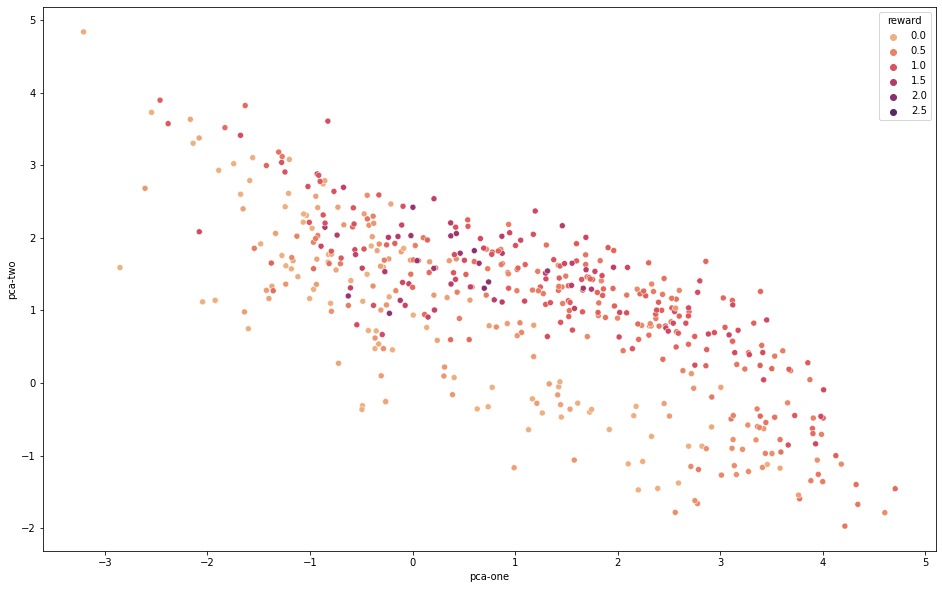

In [5]:
# 2D plot PCA
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x='pca-one', 
    y='pca-two',
    hue='reward',
    palette=sns.color_palette('flare', as_cmap=True),
    data=df,
    legend=True,
    alpha=1
)

In [6]:
# 3D plot PCA
fig = plt.figure(figsize=(13, 13))
ax = Axes3D(fig)
ax.view_init(elev=10.)

ax.scatter(
    xs=df['pca-one'], 
    ys=df['pca-two'], 
    zs=df['pca-three'], 
    c=df['reward'],
    cmap='RdPu',
    alpha=1
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')

def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig

#plt.show()
plt.close()
anim = animation.FuncAnimation(fig, animate, frames=360, interval=40)
html = anim.to_html5_video()
HTML(html)

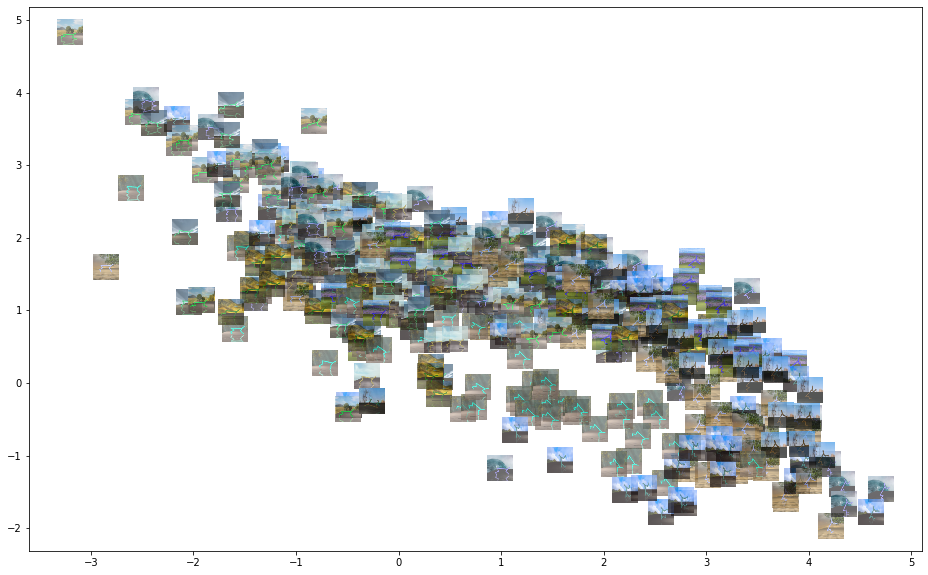

In [7]:
# 2D plot PCA images
fig, ax = plt.subplots(figsize=(16, 10))
ax.scatter(
    x=df['pca-one'], 
    y=df['pca-two'], 
    c=df['reward'],
    cmap='tab10',
    alpha=0,
    marker='o'
)

for xy, i in zip(pca_result[:, :2], images):
    x0, y0 = xy
    i = np.concatenate((i, np.ones((1, 64, 64))), axis=0)
    i[3] = 0.7
    i = np.moveaxis(np.uint8(i * 255), 0, -1)
    i = Image.fromarray(i).convert('RGBA')
    img = OffsetImage(i, zoom=0.4)
    ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
    ax.add_artist(ab)
    
plt.show()

In [24]:
# 3D plot PCA images
fig = plt.figure(figsize=(23, 23))
ax = fig.add_subplot(111, projection=Axes3D.name)
ax.view_init(elev=10.)

ax.scatter(
    xs=df['pca-one'], 
    ys=df['pca-two'],
    zs=df['pca-three'],
    c=df['label'],
    cmap='tab10',
    alpha=0,
    marker='o'
)

# Create a dummy axes to place annotations to
ax2 = fig.add_subplot(111, frame_on=False) 
ax2.axis('off')
ax2.axis([0, 1, 0, 1])


def proj(X):
    x, y, z = X
    x2, y2, _ = proj3d.proj_transform(x, y, z, ax.get_proj())
    tr = ax.transData.transform((x2, y2))
    return ax2.transData.inverted().transform(tr)

def image(arr, xy):
    arr = np.concatenate((arr, np.ones((1, 64, 64))), axis=0)
    arr[3] = 0.7
    arr = np.moveaxis(np.uint8(arr * 255), 0, -1)
    arr = Image.fromarray(arr).convert('RGBA')
    im = offsetbox.OffsetImage(arr, zoom=0.4)
    im.image.axes = ax
    ab = offsetbox.AnnotationBbox(im, xy, xycoords='data', boxcoords='offset points', frameon=False)
    ax2.add_artist(ab)
    return ab

ax.set_xlabel('tsne-3d-one')
ax.set_ylabel('tsne-3d-two')
ax.set_zlabel('tsne-3d-three')

annot = []
for s, im in zip(pca_result, images):
    x, y = proj(s)
    annot.append(image(im,[x, y]))

def animate(i):
    ax.view_init(elev=10., azim=i)
    for s,ab in zip(pca_result, annot):
        ab.xy = proj(s)
    return fig

#plt.show()
plt.close()
anim = animation.FuncAnimation(fig, animate, frames=360, interval=40)
html = anim.to_html5_video()
HTML(html)

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1656x1656', '-pix_fmt', 'rgba', '-r', '25.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/var/folders/wl/kx1cd9651t7bm6k1hbqsl28w0000gn/T/tmptfzy86_5/temp.m4v']' returned non-zero exit status 255.

<AxesSubplot:xlabel='tsne-3d-one', ylabel='tsne-3d-two'>

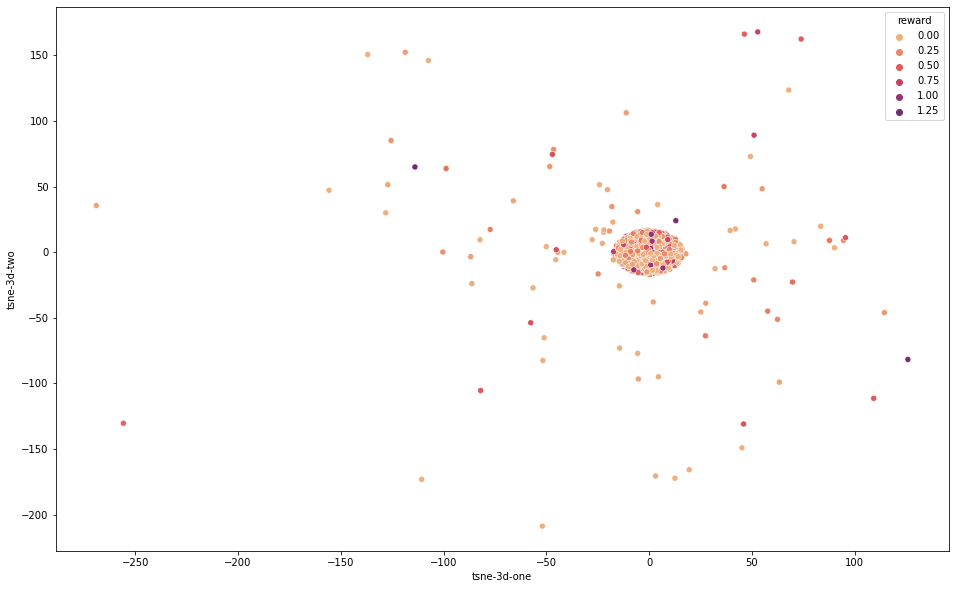

In [18]:
# 2D plot TSNE
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x='tsne-3d-one', 
    y='tsne-3d-two',
    hue='reward',
    palette=sns.color_palette('flare', as_cmap=True),
    data=df,
    legend=True,
    alpha=1
)

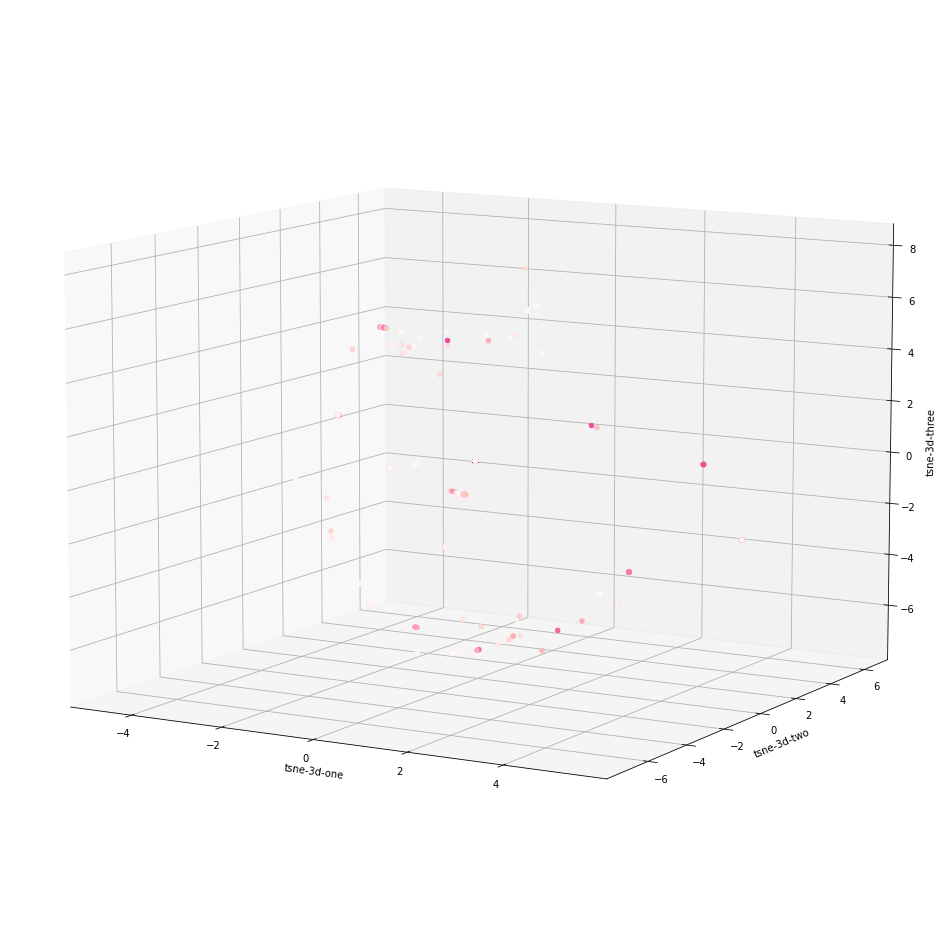

In [15]:
# 3D plot TSNE
fig = plt.figure(figsize=(13, 13))
ax = Axes3D(fig)
ax.view_init(elev=10.)

ax.scatter(
    xs=df['tsne-3d-one'], 
    ys=df['tsne-3d-two'], 
    zs=df['tsne-3d-three'], 
    c=df['reward'], 
    cmap='RdPu',
    alpha=1
)
ax.set_xlabel('tsne-3d-one')
ax.set_ylabel('tsne-3d-two')
ax.set_zlabel('tsne-3d-three')

def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig

plt.show()
#plt.close()
#anim = animation.FuncAnimation(fig, animate, frames=360, interval=40)
#html = anim.to_html5_video()
#HTML(html)

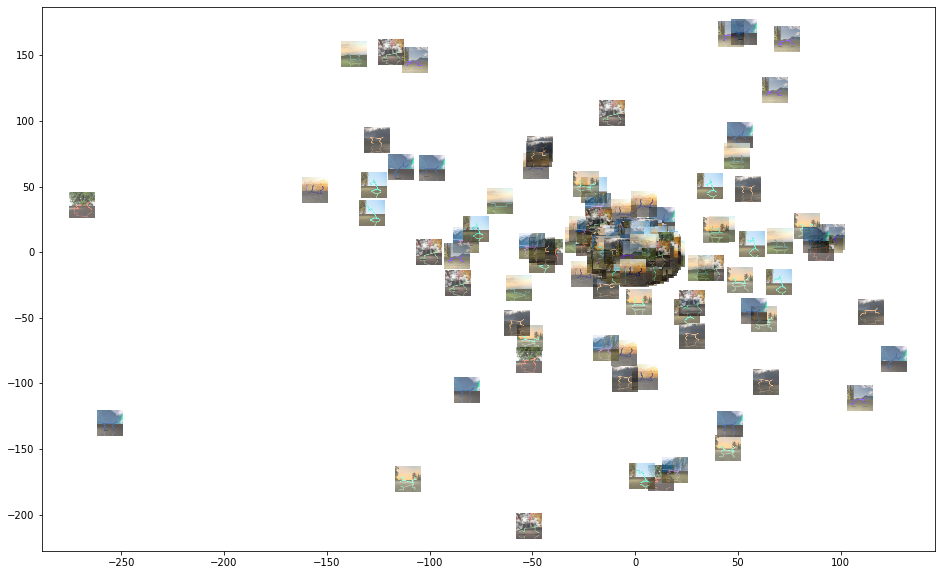

In [19]:
# 2D plot TSNE images
fig, ax = plt.subplots(figsize=(16, 10))
ax.scatter(
    x=df['tsne-3d-one'], 
    y=df['tsne-3d-two'], 
    c=df['reward'],
    cmap='tab10',
    alpha=0,
    marker='o'
)

for xy, i in zip(tsne_results[:, :2], images):
    x0, y0 = xy
    i = np.concatenate((i, np.ones((1, 64, 64))), axis=0)
    i[3] = 0.7
    i = np.moveaxis(np.uint8(i * 255), 0, -1)
    i = Image.fromarray(i).convert('RGBA')
    img = OffsetImage(i, zoom=0.4)
    ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
    ax.add_artist(ab)
    
plt.show()

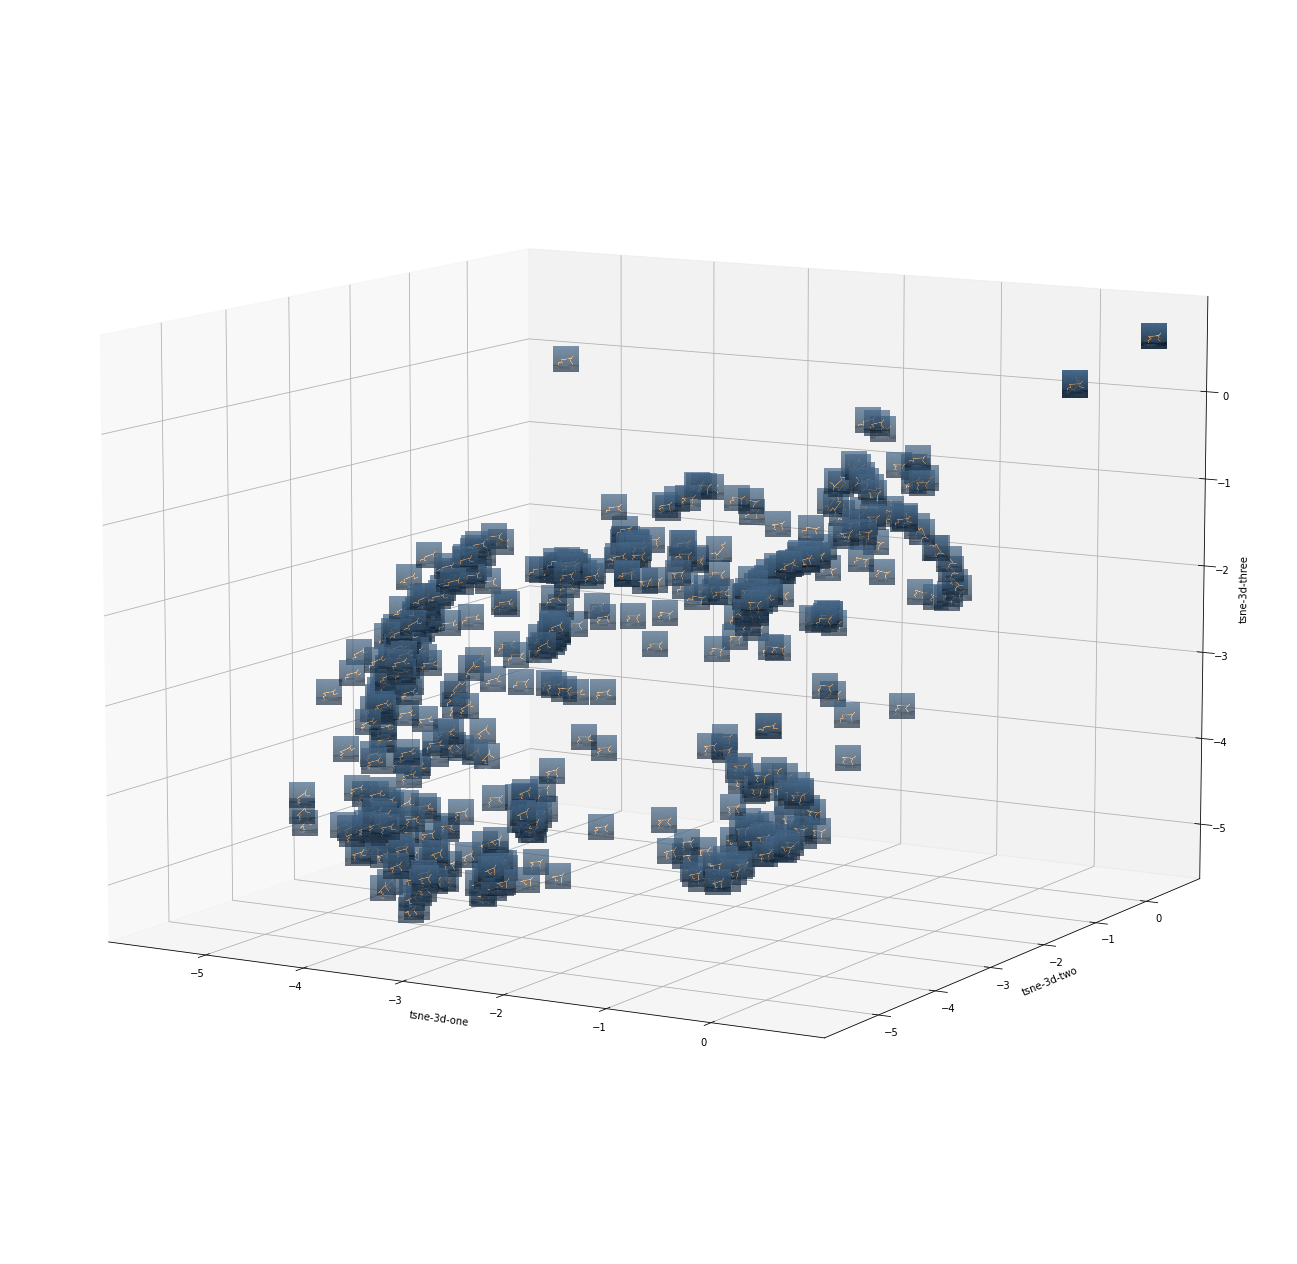

In [20]:
# 3D plot TSNE images
fig = plt.figure(figsize=(23, 23))
ax = fig.add_subplot(111, projection=Axes3D.name)
ax.view_init(elev=10.)

ax.scatter(
    xs=df['tsne-3d-one'], 
    ys=df['tsne-3d-two'],
    zs=df['tsne-3d-three'],
    c=df['reward'],
    cmap='tab10',
    alpha=0,
    marker='o'
)

# Create a dummy axes to place annotations to
ax2 = fig.add_subplot(111, frame_on=False) 
ax2.axis('off')
ax2.axis([0, 1, 0, 1])


def proj(X):
    x, y, z = X
    x2, y2, _ = proj3d.proj_transform(x, y, z, ax.get_proj())
    tr = ax.transData.transform((x2, y2))
    return ax2.transData.inverted().transform(tr)

def image(arr, xy):
    arr = np.concatenate((arr, np.ones((1, 64, 64))), axis=0)
    arr[3] = 0.7
    arr = np.moveaxis(np.uint8(arr * 255), 0, -1)
    arr = Image.fromarray(arr).convert('RGBA')
    im = offsetbox.OffsetImage(arr, zoom=0.4)
    im.image.axes = ax
    ab = offsetbox.AnnotationBbox(im, xy, xycoords='data', boxcoords='offset points', frameon=False)
    ax2.add_artist(ab)
    return ab

ax.set_xlabel('tsne-3d-one')
ax.set_ylabel('tsne-3d-two')
ax.set_zlabel('tsne-3d-three')

annot = []
for s, im in zip(tsne_results, images):
    x, y = proj(s)
    annot.append(image(im,[x, y]))

def animate(i):
    ax.view_init(elev=10., azim=i)
    for s,ab in zip(tsne_results, annot):
        ab.xy = proj(s)
    return fig

plt.show()
#plt.close()
#anim = animation.FuncAnimation(fig, animate, frames=360, interval=40)
#html = anim.to_html5_video()
#HTML(html)